# Experiment Setup: PyTorch, SPOT, RayTune, Tensorboard

## Imports

In [25]:
from functools import partial
import os
import random 

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.basic_variant import BasicVariantGenerator

In [26]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Run Tensorboard

In [22]:
%load_ext tensorboard
%tensorboard --logdir runs

# !tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 30399), started 6:01:22 ago. (Use '!kill 30399' to kill it.)

## Load Data

In [13]:
def load_data(data_dir="./data"):
    # transforms
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])

    # datasets
    trainset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=True,
        transform=transform)
    testset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=False,
        transform=transform)
    return trainset, testset

trainset, testset = load_data()

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g)


testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Utils

In [14]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Model Setup

In [15]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Tensorboard

In [9]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

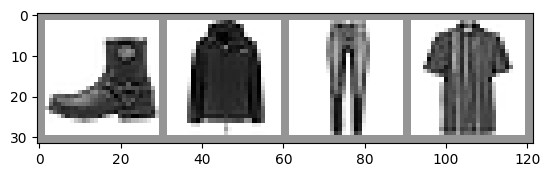

In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [12]:
writer.add_graph(net, images)
writer.close()

In [10]:
# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets, 6000)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1),
                    tag="big")
writer.close()

## Model Training

In [17]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [18]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

## RayTune Hyperparameter Tuning

In [27]:
def train_fashion_mnist(config, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        net.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs]
    )

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g
    )
    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g
    )

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        checkpoint = Checkpoint.from_dict(checkpoint_data)

        session.report(
            {"loss": val_loss / val_steps, "accuracy": correct / total},
            checkpoint=checkpoint,
        )
    print("Finished Training")

def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [28]:
config = {
    "l1": tune.choice([2 ** i for i in range(9)]),
    "l2": tune.choice([2 ** i for i in range(9)]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}


max_num_epochs = 10
num_samples = 2

# Async Hyperband Scheduler
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2,
)

result = tune.run(
    partial(train_fashion_mnist, data_dir="./data"),
    resources_per_trial={"cpu": 8, "gpu": 0},
    config=config,
    num_samples=num_samples,
    storage_path='./tune_runs/',
    search_alg=BasicVariantGenerator(random_state=42),
    scheduler=scheduler)

2023-08-04 09:07:49,138	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz


100%|██████████| 26421880/26421880 [00:02<00:00, 12208480.70it/s]


(func pid=4168) Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw
(func pid=4168) 
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


100%|██████████| 29515/29515 [00:00<00:00, 772173.67it/s]


(func pid=4168) Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
(func pid=4168) 
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


100%|██████████| 4422102/4422102 [00:00<00:00, 11263220.09it/s]


(func pid=4168) Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw
(func pid=4168) 
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
(func pid=4168) Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz


100%|██████████| 5148/5148 [00:00<00:00, 62405424.83it/s]


(func pid=4168) Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
(func pid=4168) 
(func pid=4168) [1,  2000] loss: 2.315
(func pid=4168) [1,  4000] loss: 1.162
(func pid=4168) [1,  6000] loss: 0.775


Trial name,accuracy,loss,should_checkpoint
train_fashion_mnist_9ed5a_00000,0.0993333,2.3286,True


(func pid=4168) [2,  2000] loss: 2.322
(func pid=4168) [2,  4000] loss: 1.160
(func pid=4168) [2,  6000] loss: 0.774
(func pid=4168) [3,  2000] loss: 2.322
(func pid=4168) [3,  4000] loss: 1.160
(func pid=4168) [3,  6000] loss: 0.775
(func pid=4168) [4,  2000] loss: 2.321
(func pid=4168) [4,  4000] loss: 1.161
(func pid=4168) [4,  6000] loss: 0.774
(func pid=4168) [5,  2000] loss: 2.323
(func pid=4168) [5,  4000] loss: 1.160
(func pid=4168) [5,  6000] loss: 0.774
(func pid=4168) [6,  2000] loss: 2.322
(func pid=4168) [6,  4000] loss: 1.160
(func pid=4168) [6,  6000] loss: 0.775
(func pid=4168) [7,  2000] loss: 2.323
(func pid=4168) [7,  4000] loss: 1.161
(func pid=4168) [7,  6000] loss: 0.774
(func pid=4168) [8,  2000] loss: 2.322
(func pid=4168) [8,  4000] loss: 1.162
(func pid=4168) [8,  6000] loss: 0.774
(func pid=4168) [9,  2000] loss: 2.324
(func pid=4168) [9,  4000] loss: 1.162
(func pid=4168) [9,  6000] loss: 0.774
(func pid=4168) [10,  2000] loss: 2.323
(func pid=4168) [10,  40

2023-08-04 09:13:58,162	INFO tune.py:1148 -- Total run time: 369.02 seconds (368.98 seconds for the tuning loop).


In [29]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
device = "cpu"
best_trained_model.to(device)

best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
best_checkpoint_data = best_checkpoint.to_dict()

best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

test_acc = test_accuracy(best_trained_model, device)
print("Best trial test set accuracy: {}".format(test_acc))

Best trial config: {'l1': 64, 'l2': 8, 'lr': 0.07114476009343416, 'batch_size': 8}
Best trial final validation loss: 2.3285953847567242
Best trial final validation accuracy: 0.09933333333333333
Best trial test set accuracy: 0.1


## SPOT Hyperaprameter Tuning

In [ ]:
from spotPython.utils.init import fun_control_init
from spotPython.utils.file import get_experiment_name, get_spot_tensorboard_path
from spotPython.utils.device import getDevice

In [ ]:
MAX_TIME = 1 # at least 60 for productive
INIT_SIZE = 5 # at least 10 for productive
DEVICE = "auto" # "cpu", "cuda:0"
PREFIX = "FashionMNIST"
DEVICE = getDevice(DEVICE)
print(DEVICE)

In [ ]:
experiment_name = get_experiment_name(prefix=PREFIX)

fun_control = fun_control_init(
    task="classification",
    spot_tensorboard_path=get_spot_tensorboard_path(experiment_name),
    device=DEVICE,)

In [ ]:
train, test = load_data()
fun_control.update({
    "train": train,
    "test": test,
    "n_samples": len(train)})